In [1]:

import os
import os.path as ospath
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model
from tqdm.notebook import tqdm
import seaborn as sns
from statannotations.Annotator import Annotator
import sys

In [2]:
def load_ring_data_df(dirname, filename):
    file = ospath.join(dirname, filename)

    try: 
        df = pd.read_pickle(file)
    except FileNotFoundError:
        print("No ring_data_filter.pkl file was found.")
        return None
    else: 
        return df
    
def linear(x,a,b):
    return a * x + b

def linear_0(x,a):
    return a * x

def fit_model(use_model, x_vals, y_vals, a_init, b_init):

    mod = Model(use_model)
    
    mod.set_param_hint('a', value = a_init, vary = True)
    if use_model == linear:
        mod.set_param_hint('b', value = b_init, vary = True, min = 0.0) #
    pars = mod.make_params()
    result = mod.fit(y_vals, x = x_vals, params = pars)

    #popt, _ = curve_fit(linearb, width_unique, min_radius_sel_list)
    #a, b = popt
    #print(result.values['a'])
    a = result.values['a']
    if use_model == linear:
        b = result.values['b']
        
        return a, b
    
    else:
        return a, 0

    
    
def ax_add_fit(use_model, a, b, x_vals, ax, label = None, color = 'red', pos_anotate = (0.05,0.6)):      
    # define a sequence of inputs between 0 and the largest known inputs
    x_line = np.arange(0, max(x_vals)+1, 1)
    # calculate the output for the range
    if use_model == linear:
        y_line = linear(x_line, a, b)
    if use_model == linear_0:
        y_line = linear_0(x_line, a)
    # create a line plot for the mapping function
    ax.plot(x_line, y_line, '--', color=color, label = label)
    if use_model == linear:
        ax.annotate('y = %.03g * x + %.03g' % (a, b), pos_anotate, xycoords = 'axes fraction', c = color)
    if use_model == linear_0:
        ax.annotate('y = %.03g * x' % (a), pos_anotate, xycoords = 'axes fraction', c = color)
        
    return ax


In [3]:
path = r'W:\users\reinhardt\z.software\Git\spor-PAINT\dev_sr\spor-paint\SepF\picked_rings_SepF_working'


ring_data_filename = 'ring_data_unfold_filter'
folder_suffix = ''


N_min_fit = 3 # minimal number of spor or veg rings in a FOV to perform a linear fit

# Which function should be fitted: 
# linear:    y = a * x + b
# linear_0:  y = a * x
use_model = linear_0 


df = load_ring_data_df(path, ring_data_filename + ".pkl")

Processing FOVs:   0%|          | 0/14 [00:00<?, ?it/s]

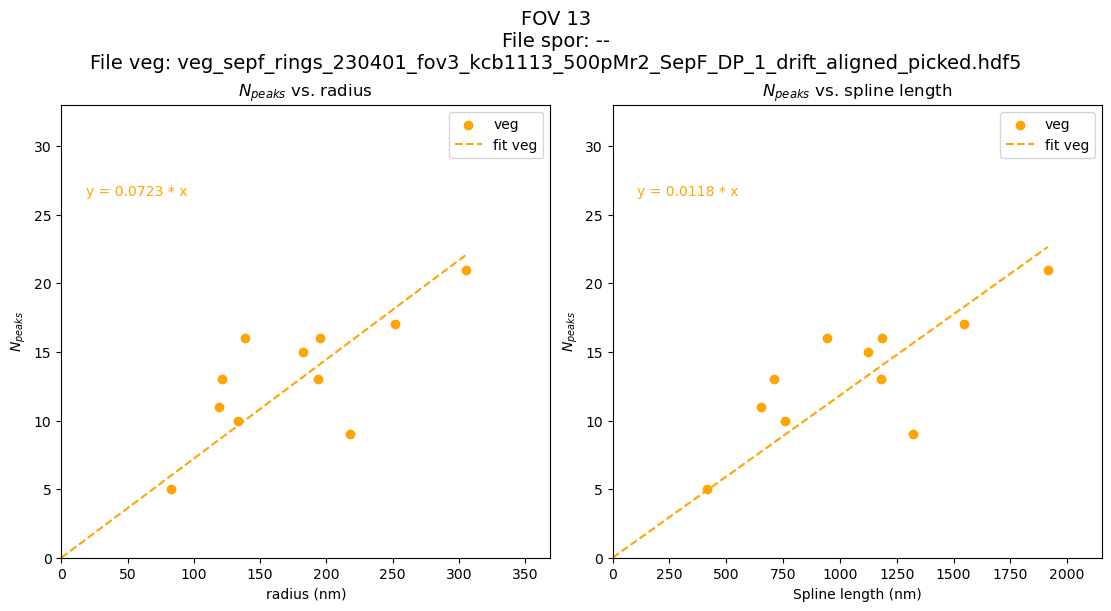

In [8]:
fov_id_max = df['fov_id'].max()

df_filter = df[df['spline_filter_passed']=='Yes']

# range for x or y axis:
radius_min = df_filter['radius'].min()
radius_max = df_filter['radius'].max() + 50
spline_length_min = df_filter['spline_length'].min()
spline_length_max = df_filter['spline_length'].max() + 50

N_min = df_filter['N_peaks'].min()
N_max = df_filter['N_peaks'].max()+5


plots_folder = os.path.join(path, 'analysis', 'plots_N_peaks')
if not os.path.isdir(plots_folder):
    os.makedirs(plots_folder)



fit_radius_result = []
fit_spline_result = []

for fov_id in tqdm(range(fov_id_max), desc="Processing FOVs"):
    plt.close('all')
    
    df_fov_id_spor = df_filter[(df_filter['fov_id']==fov_id) & (df_filter['cell_type']=='spor')]
    df_fov_id_veg = df_filter[(df_filter['fov_id']==fov_id) & (df_filter['cell_type']=='veg')]
    
    if (len(df_fov_id_spor)==0):
        plot_spor = False
    else: 
        plot_spor = True
    
    if (len(df_fov_id_veg)==0):
        plot_veg = False
    else: 
        plot_veg = True

    if plot_spor == False and plot_veg == False:
        continue
    
    
    
    fig = plt.figure(figsize=(11, 6), constrained_layout=True) 
    gs = fig.add_gridspec(1,2)

    if plot_spor:
        filename_spor = df_fov_id_spor['filename'].iloc[0]
    else:
        filename_spor = '--'
        
    if plot_veg:
        filename_veg = df_fov_id_veg['filename'].iloc[0]
    else:
        filename_veg = '--'
    
    fig.suptitle(("FOV {}\n"
                  "File spor: {}\n"
                  "File veg: {}").format(fov_id, filename_spor, filename_veg), 
                 fontsize=14, 
                 ha="center")
    
    
    # plot N_peaks vs. radius
    ax1 = fig.add_subplot(gs[0, 0])  
    ax1.set_title(r'$N_{peaks}$ vs. radius', 
                 fontsize=12, 
                 ha="center")
    

    ax1.set_xlabel('radius (nm)')
    ax1.set_ylabel(r'$N_{peaks}$')
    
    if plot_spor:
        ax1.scatter(df_fov_id_spor['radius'], df_fov_id_spor['N_peaks'], label = 'spor', color = 'blue')
    if plot_veg:
        ax1.scatter(df_fov_id_veg['radius'], df_fov_id_veg['N_peaks'], label = 'veg', color = 'orange')
    
    if plot_spor and len(df_fov_id_spor) >= N_min_fit:
        a_spor, b_spor = fit_model(use_model, x_vals = df_fov_id_spor['radius'], y_vals = df_fov_id_spor['N_peaks'], a_init = 1, b_init = 0)
        ax1 = ax_add_fit(use_model, a_spor, b_spor, x_vals = df_fov_id_spor['radius'], ax = ax1, label = 'fit spor', color = 'blue', pos_anotate = (0.05,0.9))
        fit_radius_result.append([fov_id, 'spor', a_spor, b_spor])
    if plot_veg and len(df_fov_id_veg) >= N_min_fit:
        a_veg, b_veg = fit_model(use_model, x_vals = df_fov_id_veg['radius'], y_vals = df_fov_id_veg['N_peaks'], a_init = 1, b_init = 0)
        ax1 = ax_add_fit(use_model, a_veg, b_veg, x_vals = df_fov_id_veg['radius'], ax = ax1, label = 'fit veg', color = 'orange', pos_anotate = (0.05,0.8))
        fit_radius_result.append([fov_id, 'veg', a_veg, b_veg])
        
    ax1.set_xlim(0, radius_max)
    ax1.set_ylim(0, N_max)
    ax1.legend()
    
    # plot N_peaks vs. spline length
    ax2 = fig.add_subplot(gs[0, 1])  
    ax2.set_title(r'$N_{peaks}$ vs. spline length', 
                 fontsize=12, 
                 ha="center")
    

    ax2.set_xlabel('Spline length (nm)')
    ax2.set_ylabel(r'$N_{peaks}$')
    
    if plot_spor:
        ax2.scatter(df_fov_id_spor['spline_length'], df_fov_id_spor['N_peaks'], label = 'spor', color = 'blue')
    if plot_veg:
        ax2.scatter(df_fov_id_veg['spline_length'], df_fov_id_veg['N_peaks'], label = 'veg', color = 'orange')
    
    if plot_spor and len(df_fov_id_spor) >= N_min_fit:
        a_spor, b_spor = fit_model(use_model, x_vals = df_fov_id_spor['spline_length'], y_vals = df_fov_id_spor['N_peaks'], a_init = 1, b_init = 0)
        ax2 = ax_add_fit(use_model, a_spor, b_spor, x_vals = df_fov_id_spor['spline_length'], ax = ax2, label = 'fit spor', color = 'blue', pos_anotate = (0.05,0.9))
        fit_spline_result.append([fov_id, 'spor', a_spor, b_spor])
    if plot_veg and len(df_fov_id_veg) >= N_min_fit:
        a_veg, b_veg = fit_model(use_model, x_vals = df_fov_id_veg['spline_length'], y_vals = df_fov_id_veg['N_peaks'], a_init = 1, b_init = 0)
        ax2 = ax_add_fit(use_model, a_veg, b_veg, x_vals = df_fov_id_veg['spline_length'], ax = ax2, label = 'fit veg', color = 'orange', pos_anotate = (0.05,0.8))
        fit_spline_result.append([fov_id, 'veg', a_veg, b_veg])
        
    ax2.set_xlim(0, spline_length_max)
    ax2.set_ylim(0, N_max)
    ax2.legend()
    
    

    fig.savefig(os.path.join(plots_folder, 'fov_{}'.format(fov_id)))
    
    
    

# Safe fit results
df_fit_radius_all = pd.DataFrame(fit_radius_result, columns=["fov_id",
                                                "cell_type",
                                                "a",
                                                "b"
                                               ])

df_fit_radius_all.to_csv(os.path.join(plots_folder, "fit_result_Npeaks_radius.csv"))        
# Save dataframe with cell means for easy loading of data for postprocessing
df_fit_radius_all.to_pickle(os.path.join(plots_folder, "fit_result_Npeaks_radius.pkl"))

# Safe fit results
df_fit_spline_all = pd.DataFrame(fit_spline_result, columns=["fov_id",
                                                "cell_type",
                                                "a",
                                                "b"
                                               ])

df_fit_spline_all.to_csv(os.path.join(plots_folder, "fit_result_Npeaks_splineLength.csv"))        
# Save dataframe with cell means for easy loading of data for postprocessing
df_fit_spline_all.to_pickle(os.path.join(plots_folder, "fit_result_Npeaks_splineLength.pkl"))

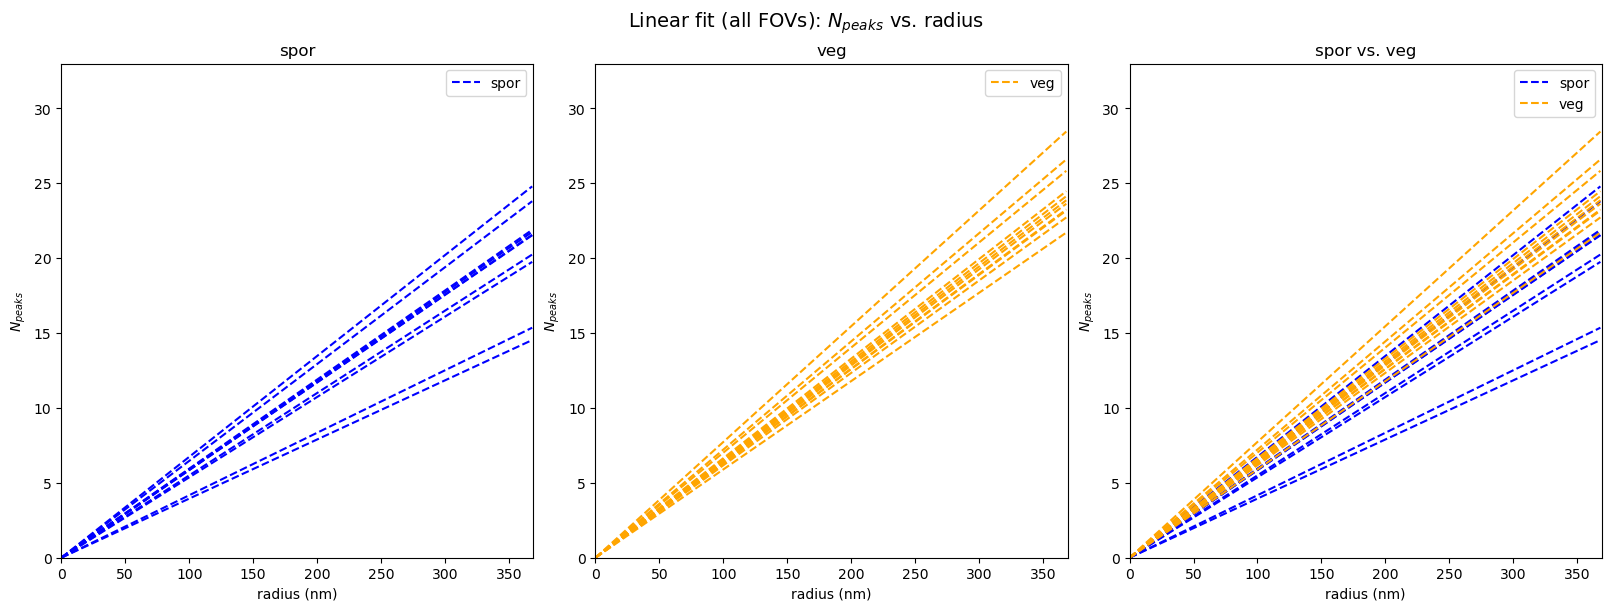

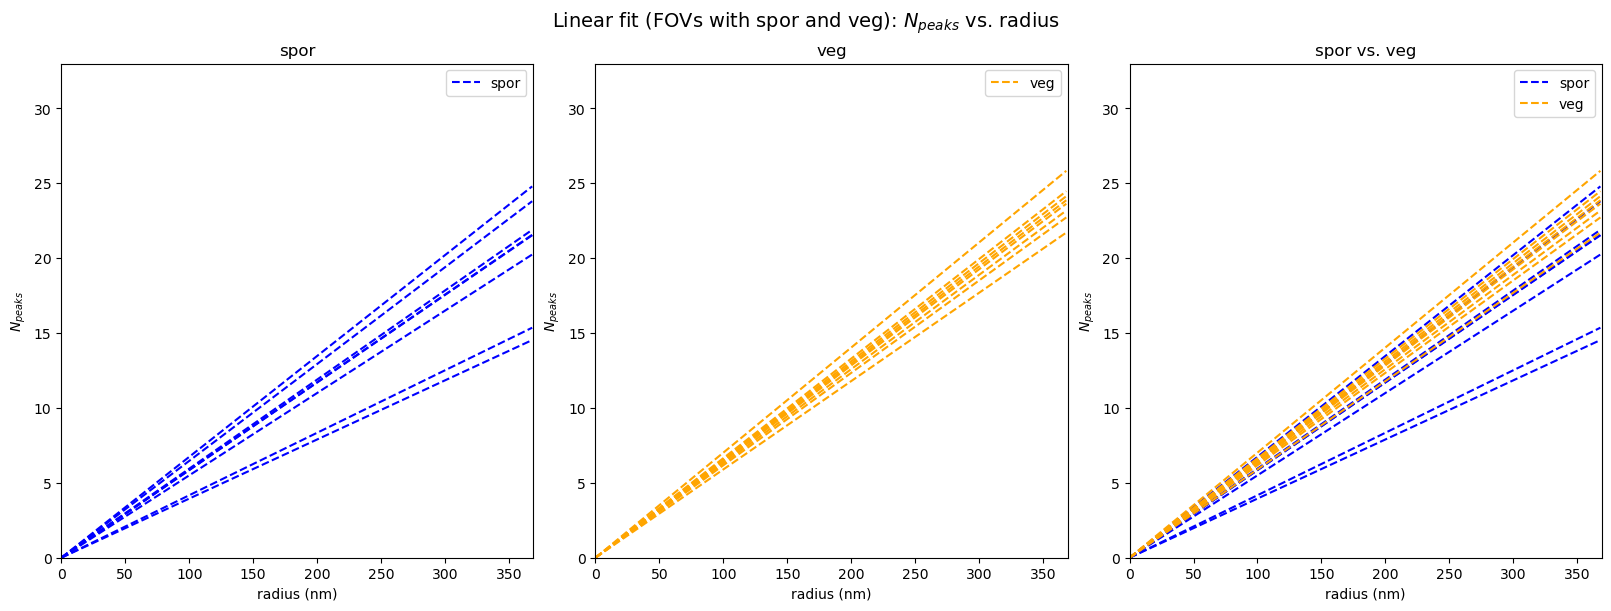

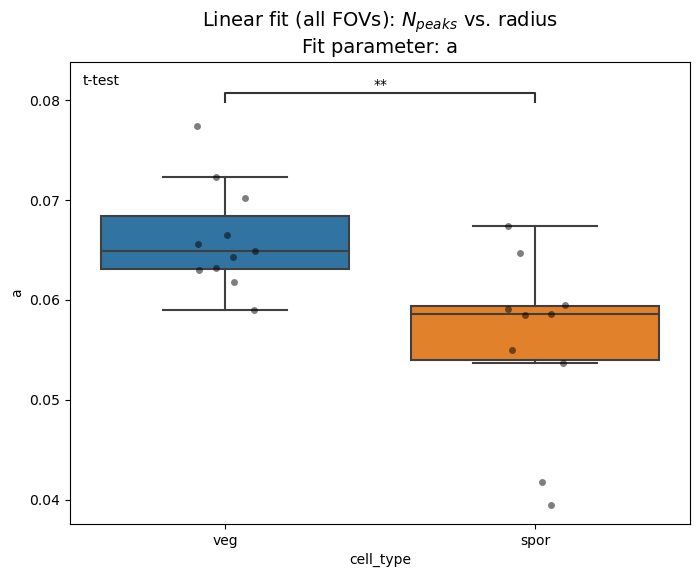

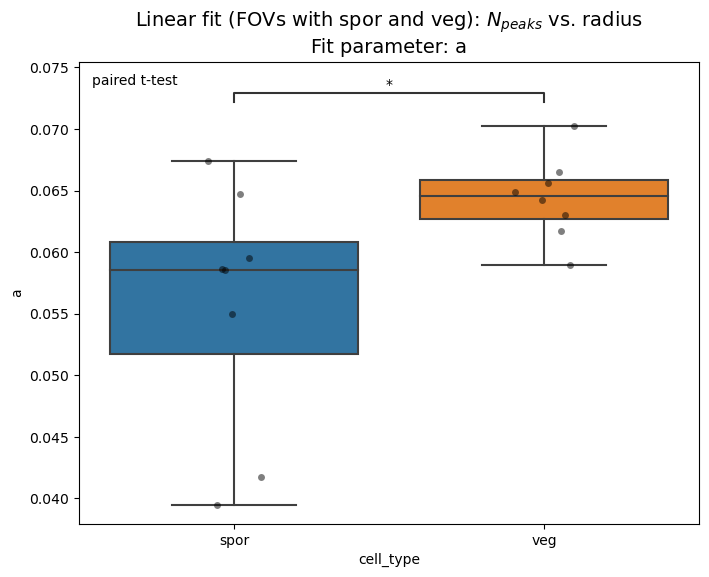

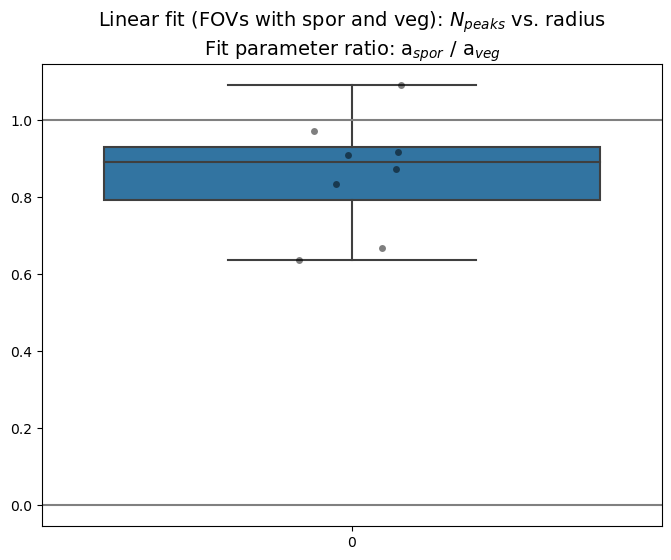

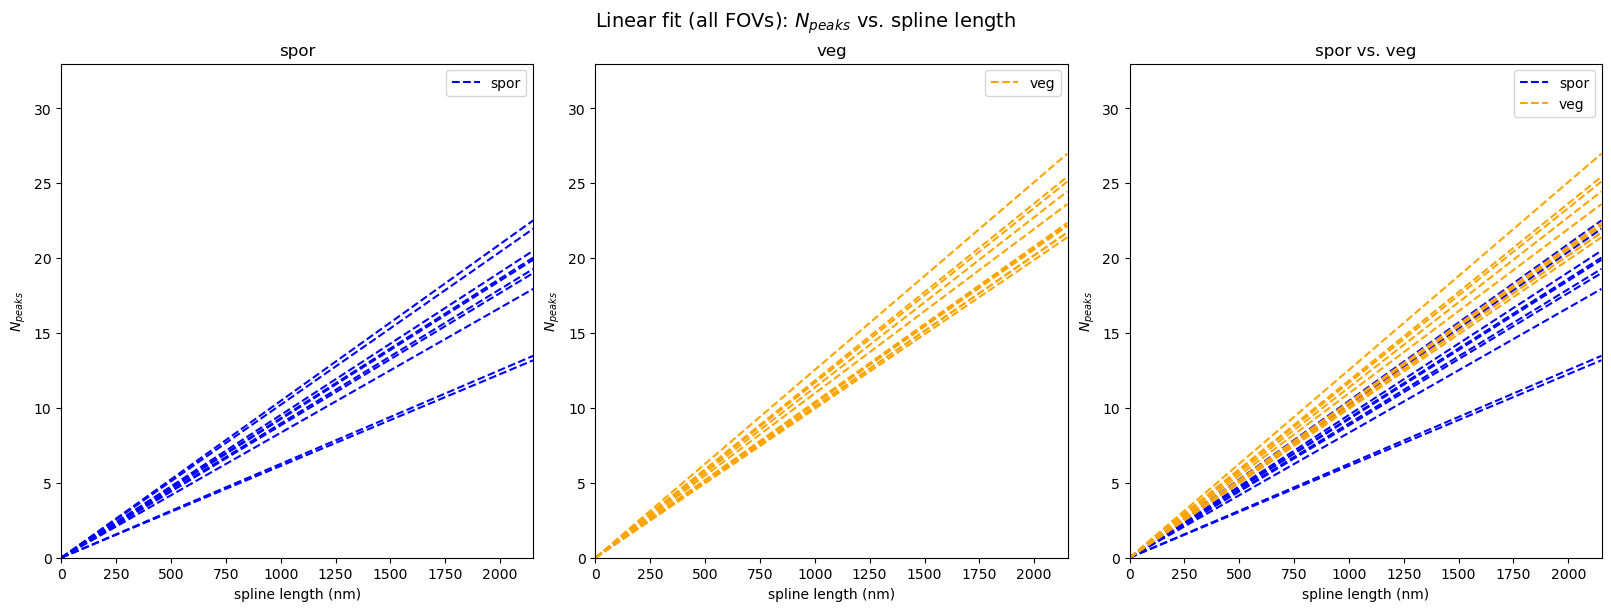

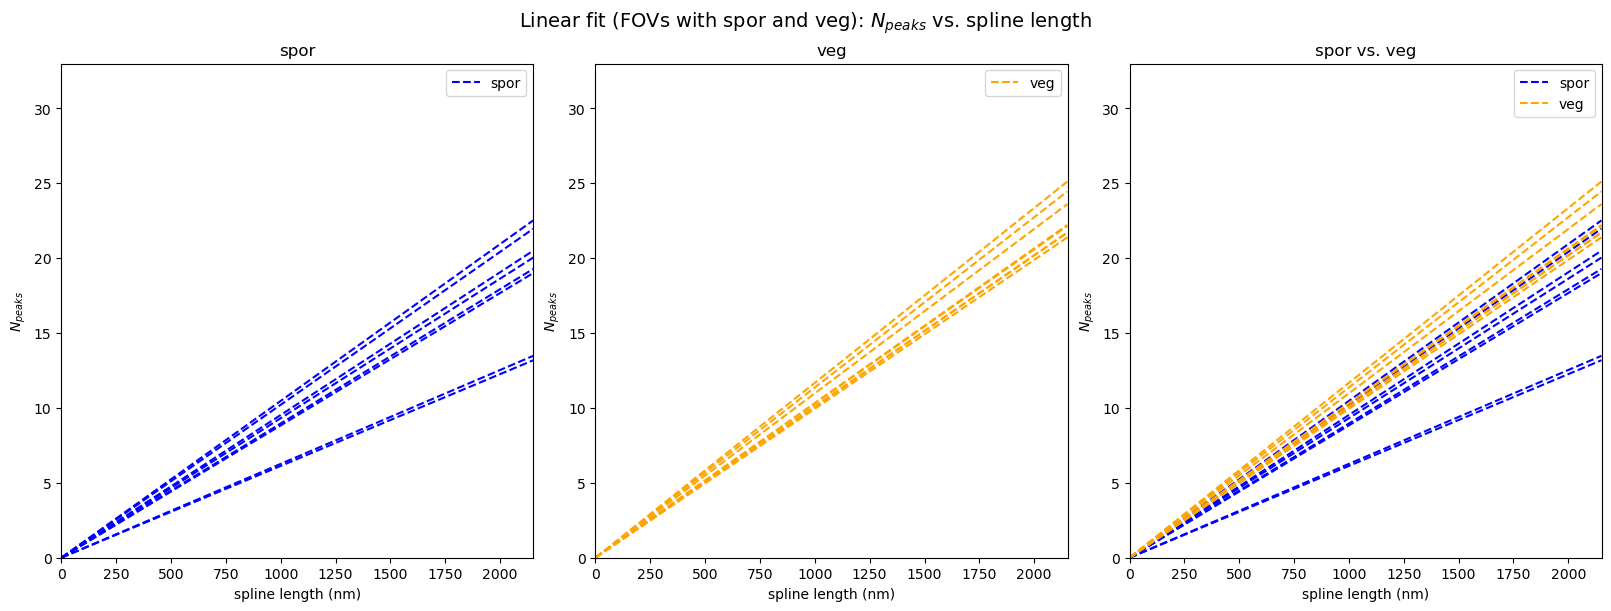

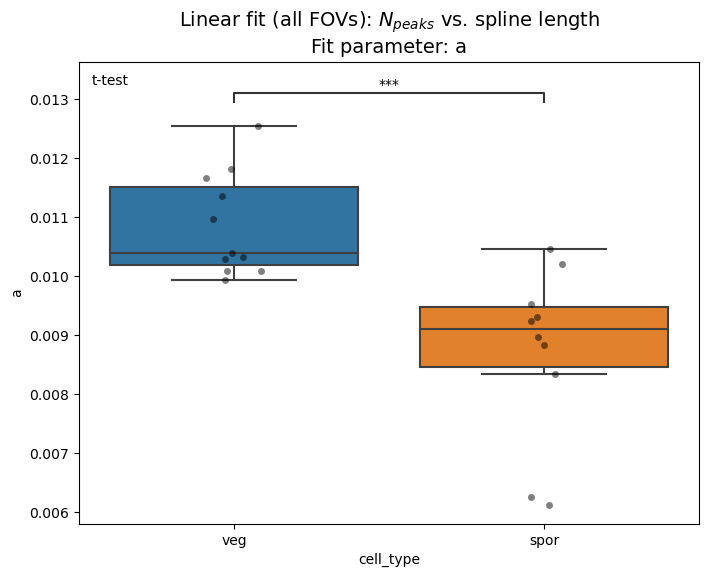

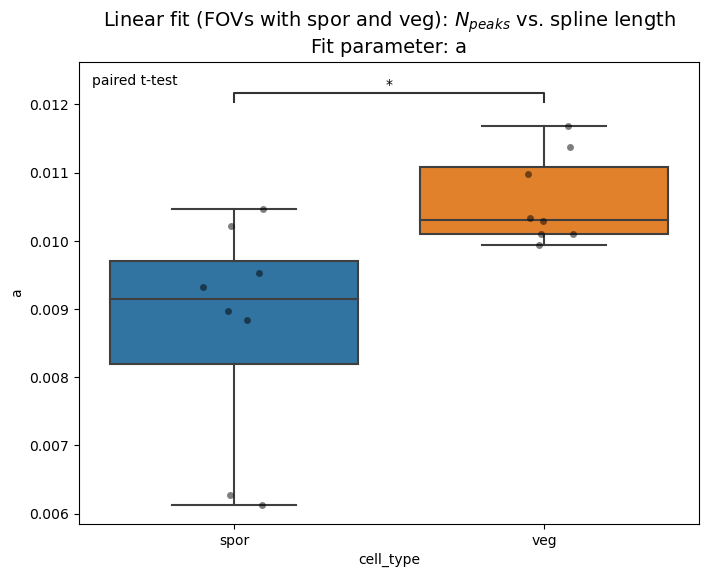

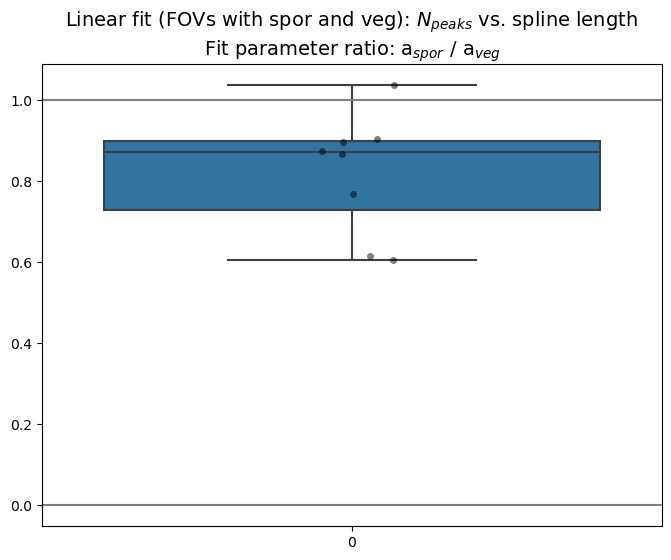

In [10]:
load_results = False

if load_results:
    df_fit_results_all = pd.read_pickle(os.path.join(plots_folder, "fit_result.csv"))


def ax_add_fits(df_fit_results, cell_type, use_model, x_line, ax, color = 'red'):

    counter = 0
    for index, row in df_fit_results.iterrows():
            
        if row['cell_type'] == cell_type:
            a = row['a']
            b = row['b']
            if use_model == linear:
                y_line = linear(x_line, a, b)
            if use_model == linear_0:
                y_line = linear_0(x_line, a)
            
            if counter == 0:
                ax.plot(x_line, y_line, '--', color=color, label = cell_type)
            else:
                ax.plot(x_line, y_line, '--', color=color)
            counter +=1
    return ax

def plot_spor_and_veg_fits(df_fit_results, use_model, title, x_label, y_label, xlim, ylim):
    # Plot all fit functions

    fig = plt.figure(figsize=(16, 6), constrained_layout=True)
    gs = fig.add_gridspec(1,3)


    fig.suptitle(title, fontsize=14, ha="center")

    x_line = np.arange(0, xlim, 1)

    # plot 1/dark time vs. radius for spor
    ax1 = fig.add_subplot(gs[0, 0])  
    ax1.set_title('spor', fontsize=12, ha="center")

    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y_label)

    ax1 = ax_add_fits(df_fit_results, 'spor', use_model, x_line, ax1, color = 'blue')


    ax1.set_xlim(0, xlim)
    ax1.set_ylim(0, ylim)
    ax1.legend()

    # plot 1/dark time vs. radius for veg
    ax2 = fig.add_subplot(gs[0, 1])  
    ax2.set_title('veg', fontsize=12, ha="center")

    ax2.set_xlabel(x_label)
    ax2.set_ylabel(y_label)

    ax2 = ax_add_fits(df_fit_results, 'veg', use_model, x_line, ax2, color = 'orange')


    ax2.set_xlim(0, xlim)
    ax2.set_ylim(0, ylim)
    ax2.legend()

    # plot 1/dark time vs. radius for veg
    ax3 = fig.add_subplot(gs[0, 2])  
    ax3.set_title('spor vs. veg', fontsize=12, ha="center")

    ax3.set_xlabel(x_label)
    ax3.set_ylabel(y_label)

    ax3 = ax_add_fits(df_fit_results, 'spor', use_model, x_line, ax3, color = 'blue')
    ax3 = ax_add_fits(df_fit_results, 'veg', use_model, x_line, ax3, color = 'orange')


    ax3.set_xlim(0, xlim)
    ax3.set_ylim(0, ylim)
    ax3.legend()

    return fig

def plot_fit_param(df_fit_results, parameter, ylim_min, ylim_max, title, independent_t_test = False, paired_t_test = False, filename_test_results = 'test'):
    fig = plt.figure(figsize=(8, 6))


    ax = fig.add_subplot()  
    ax.set_title(title + "\n"
                 r"Fit parameter: " + parameter, fontsize=14, ha="center")

    sns.boxplot(data = df_fit_results, x='cell_type', y=parameter, fliersize=0)

    if independent_t_test or paired_t_test:
            
        # Save test results to a txt file
        temp = sys.stdout
        sys.stdout = open(os.path.join(plots_folder, filename_test_results + '.txt'),'wt')
        

        annot_spor_veg = Annotator(data = df_fit_results, x='cell_type', y=parameter, 
                          ax = ax, 
                          pairs = [('spor', 'veg')])
        annot_spor_veg.new_plot(data = df_fit_results, x='cell_type', y=parameter,
                      ax = ax, 
                      pairs = [('spor', 'veg')])
        if independent_t_test:
            # independent t test
            annot_spor_veg.configure(test = 't-test_ind', verbose = 2) # , alpha = 0.05 # produces warning if alpha is changed
            ax.annotate('t-test', (0.02,0.95), xycoords = 'axes fraction')

        if paired_t_test:
            # paired t test
            annot_spor_veg.configure(test = 't-test_paired', verbose = 2) # , alpha = 0.05 # produces warning if alpha is changed
            ax.annotate('paired t-test', (0.02,0.95), xycoords = 'axes fraction')
        
        annot_spor_veg.apply_test()
        annot_spor_veg.annotate() 
        
        sys.stdout = temp


    sns.stripplot(data = df_fit_results, x='cell_type', y=parameter,
                       marker='o', 
                       alpha=0.5,
                       color='black')
    #ax.set_ylim(ylim_min, ylim_max)

    return fig


def plot_fit_param_rel(df_fit_results_select, parameter, title):
    fig = plt.figure(figsize=(8, 6))


    ax = fig.add_subplot()  
    ax.set_title(title + "\n"
                 r"Fit parameter ratio: "+ parameter +"$_{spor}$ / "+ parameter +"$_{veg}$", fontsize=14, ha="center")
        
        
    #r"Linear fit (" + str(fov_description) + "): parameter ("+ parameter +"$_{spor}$ / "+ parameter +"$_{veg}$)", fontsize=14, ha="center")

    df_fit_results_select_spor = df_fit_results_select[df_fit_results_select['cell_type']=='spor'].set_index('fov_id')
    df_fit_results_select_veg = df_fit_results_select[df_fit_results_select['cell_type']=='veg'].set_index('fov_id')

    index_spor = df_fit_results_select_spor.index
    index_veg = df_fit_results_select_veg.index

    if not index_spor.equals(index_veg):
        raise Exception('Spor and veg fit results of same FOV could not be related!')

    a_rel = df_fit_results_select_spor[parameter] / df_fit_results_select_veg[parameter]
    a_rel = a_rel.values
    sns.boxplot(data = a_rel, fliersize=0)
    sns.stripplot(data = a_rel,
                       marker='o', 
                       alpha=0.5,
                       color='black')
    ax.axhline(y = 1, color = 'gray')
    ax.axhline(y = 0, color = 'gray')
    
    return fig

################
# Fit results: N_peaks over radius
################

# Fits of all FOVs (spor or veg) with > 2 datapoings
fig = plot_spor_and_veg_fits(df_fit_radius_all, use_model, r"Linear fit (all FOVs): $N_{peaks}$ vs. radius", 'radius (nm)', r'$N_{peaks}$', radius_max, N_max)
#fig.savefig(os.path.join(plots_folder, 'fov_fits_dark_time_radius_all'))
fig.savefig(os.path.join(plots_folder, 'fov_all-fits_Npeaks_radius'))

# FOVs with spor and veg cells with each more than > 2 datapoints
fov_id_counts = df_fit_radius_all['fov_id'].value_counts()
fov_id_spor_and_veg = fov_id_counts[fov_id_counts == 2].index.values
df_fit_radius_select = df_fit_radius_all[df_fit_radius_all['fov_id'].isin(fov_id_spor_and_veg)]
fig = plot_spor_and_veg_fits(df_fit_radius_select, use_model, r"Linear fit (FOVs with spor and veg): $N_{peaks}$ vs. radius", 'radius (nm)', r'$N_{peaks}$', radius_max, N_max)
#fig.savefig(os.path.join(plots_folder, 'fov_fits_dark_time_radius_spor_and_veg'))
fig.savefig(os.path.join(plots_folder, 'fov_spor_and_veg-fits_Npeaks_radius'))



# Plot fit params
# Fits of all FOVs (spor or veg) with > 2 datapoings

a_max = df_fit_radius_all['a'].max() + 0.00002

filename = 'fov_all_fits_Npeaks_radius-a'
fig = plot_fit_param(df_fit_radius_all, 'a', 0, a_max, r'Linear fit (all FOVs): $N_{peaks}$ vs. radius', independent_t_test = True, filename_test_results=filename)
#fig.savefig(os.path.join(plots_folder, 'fov_fits_dark_time_radius_slopes_all'))
fig.savefig(os.path.join(plots_folder, filename))

# FOVs with spor and veg cells with each more than > 2 datapoints
filename = 'fov_spor_and_veg-fits_Npeaks_radius-a'
fig = plot_fit_param(df_fit_radius_select, 'a', 0, a_max, r'Linear fit (FOVs with spor and veg): $N_{peaks}$ vs. radius', paired_t_test = True, filename_test_results=filename)
#fig.savefig(os.path.join(plots_folder, 'fov_fits_dark_time_radius_slopes_spor_and_veg'))
fig.savefig(os.path.join(plots_folder, filename))


# Plot a_spor / a_veg for each fov
# FOVs with spor and veg cells with each more than > 2 datapoints


fig = plot_fit_param_rel(df_fit_radius_select, 'a', title = r'Linear fit (FOVs with spor and veg): $N_{peaks}$ vs. radius')
#fig.savefig(os.path.join(plots_folder, 'fov_fits_dark_time_radius_rel_slopes_spor_and_veg'))
fig.savefig(os.path.join(plots_folder, 'fov_spor_and_veg-fits_Npeaks_radius-a_spor_div_a_veg'))



################
# Fit results: N_peaks over spline length
################

# Fits of all FOVs (spor or veg) with > 2 datapoings
fig = plot_spor_and_veg_fits(df_fit_spline_all, use_model, r"Linear fit (all FOVs): $N_{peaks}$ vs. spline length", 'spline length (nm)', r'$N_{peaks}$', spline_length_max, N_max)
#fig.savefig(os.path.join(plots_folder, 'fov_fits_dark_time_radius_all'))
fig.savefig(os.path.join(plots_folder, 'fov_all-fits_Npeaks_splineLength'))

# FOVs with spor and veg cells with each more than > 2 datapoints
fov_id_counts = df_fit_spline_all['fov_id'].value_counts()
fov_id_spor_and_veg = fov_id_counts[fov_id_counts == 2].index.values
df_fit_spline_select = df_fit_spline_all[df_fit_spline_all['fov_id'].isin(fov_id_spor_and_veg)]
fig = plot_spor_and_veg_fits(df_fit_spline_select, use_model, r"Linear fit (FOVs with spor and veg): $N_{peaks}$ vs. spline length", 'spline length (nm)', r'$N_{peaks}$', spline_length_max, N_max)
#fig.savefig(os.path.join(plots_folder, 'fov_fits_dark_time_radius_spor_and_veg'))
fig.savefig(os.path.join(plots_folder, 'fov_spor_and_veg-fits_Npeaks_splineLength'))



# Plot fit params
# Fits of all FOVs (spor or veg) with > 2 datapoings

a_max = df_fit_spline_all['a'].max() + 0.00002

filename = 'fov_all_fits_Npeaks_splineLength-a'
fig = plot_fit_param(df_fit_spline_all, 'a', 0, a_max, r'Linear fit (all FOVs): $N_{peaks}$ vs. spline length', independent_t_test = True, filename_test_results=filename)
#fig.savefig(os.path.join(plots_folder, 'fov_fits_dark_time_radius_slopes_all'))
fig.savefig(os.path.join(plots_folder, filename))

# FOVs with spor and veg cells with each more than > 2 datapoints
filename = 'fov_spor_and_veg-fits_Npeaks_splineLength-a'
fig = plot_fit_param(df_fit_spline_select, 'a', 0, a_max, r'Linear fit (FOVs with spor and veg): $N_{peaks}$ vs. spline length', paired_t_test = True, filename_test_results=filename)
#fig.savefig(os.path.join(plots_folder, 'fov_fits_dark_time_radius_slopes_spor_and_veg'))
fig.savefig(os.path.join(plots_folder, filename))


# Plot a_spor / a_veg for each fov
# FOVs with spor and veg cells with each more than > 2 datapoints


fig = plot_fit_param_rel(df_fit_spline_select, 'a', title = r'Linear fit (FOVs with spor and veg): $N_{peaks}$ vs. spline length')
#fig.savefig(os.path.join(plots_folder, 'fov_fits_dark_time_radius_rel_slopes_spor_and_veg'))
fig.savefig(os.path.join(plots_folder, 'fov_spor_and_veg-fits_Npeaks_splineLength-a_spor_div_a_veg'))
